In [1]:
import os
import sys

current_dir = os.getcwd()

# Walk up the directory tree until we find 'src'
path = current_dir
src_path = None

while True:
    if os.path.basename(path) == "src":
        src_path = path
        break
    parent = os.path.dirname(path)
    if parent == path:  # reached filesystem root
        break
    path = parent

# Add src to sys.path if found
if src_path and src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import AutoRec model and data utilities
from utils.model import AutoRec
from utils.autorecdata import AutoRecData
from utils.preprocessor import PreProcessor
from helpers.data_downloader import download_ml1m_dataset
# Import external libraries
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
print("=" * 70)
print("Imports Successful")
print("=" * 70)

Imports Successful


/Users/abbas/Documents/Codes/thesis/recommender/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')
data_path = os.path.join(data_dir,'ml-1m', 'ratings.dat')
print(data_path)
print(data_dir)
# Check if file exists
if not os.path.exists(data_path):
    download_ml1m_dataset(data_dir=data_dir)

def load_ml_1m_data(data_path = data_path) -> pd.DataFrame:  
    print("=" * 70)
    print("Loading MovieLens 1M Dataset")
    print("=" * 70)
    print(f"Data path: {data_path}")
    return pd.read_csv(
        data_path,
        sep='::',
        header=None,
        names=['user_id', 'item_id', 'rating', 'timestamp'],
        engine='python',  # Explicitly use python engine to avoid warning
        dtype={
            'user_id': np.int32,
            'item_id': np.int32,
            'rating': np.float32,
            'timestamp': np.int32
        }
    )


# Load ratings data with proper engine to avoid warnings
print("\nLoading ratings data...")

ratings_df = load_ml_1m_data()

print(f"✓ Successfully loaded {len(ratings_df):,} ratings")
print("=" * 70)

/Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat
/Users/abbas/Documents/Codes/thesis/recommender/src/../data

Loading ratings data...
Loading MovieLens 1M Dataset
Data path: /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat
✓ Successfully loaded 1,000,209 ratings


In [3]:
# Create PreProcessor instance
preprocessor = PreProcessor()

# Preprocess the data: split into train/test and create rating matrices
print("\nSplitting data into train/test sets and creating rating matrices...")
print("=" * 70)
train_mat, test_mat, num_users, num_items = preprocessor.preprocess_ml1m_data(
    ratings_df, 
    test_size=0.2,  # 20% for testing
    random_state=42  # For reproducibility
)

print(f"✓ Data preprocessing complete!")
print("=" * 70)


Splitting data into train/test sets and creating rating matrices...
✓ Data preprocessing complete!


In [4]:
train_set = AutoRecData(data=train_mat)
test_set = AutoRecData(data=test_mat)

In [5]:
train_loader = data.DataLoader(
    dataset=train_set,
    batch_size=256,
    shuffle=True,
    num_workers=0,
)
print('Train loader created')
print("=" * 70)
test_loader = data.DataLoader(
    dataset=test_set, batch_size=len(test_set), shuffle=False, num_workers=0
)
print('Test loader created')
print("=" * 70)

Train loader created
Test loader created


In [6]:
# Set device (CPU or CUDA if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = AutoRec(
    num_users=num_users,
    num_items=num_items,
    num_hidden_units=500,
).to(device)

Using device: cpu


In [7]:
loss_f = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=0.01,
)

best_epoch, best_rmse = 0, np.inf
best_hr_at_10, best_ndcg_at_10 = 0.0, 0.0


print(model)

AutoRec(
  (encoder): Sequential(
    (0): Linear(in_features=3706, out_features=500, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=3706, bias=True)
  )
)


In [8]:
from utils.helper import get_metrics, get_ranking_metrics

# Lists to store metrics for visualization
train_losses = []
train_rmses = []
train_hr_at_10 = []
train_ndcg_at_10 = []

for epoch in tqdm(range(40)):
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    
    for input_vec in train_loader:
        input_mask = (input_vec > 0).to(device)
        input_vec = input_vec.float().to(device)

        model.zero_grad()
        reconstruction = model(input_vec)
        loss = loss_f(reconstruction * input_mask, input_vec * input_mask)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average training loss for this epoch
    avg_train_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    train_losses.append(avg_train_loss)

    model.eval()
    rmse = get_metrics(model=model, train_set=train_set, test_set=test_set, device=device)
    hr_at_10, ndcg_at_10 = get_ranking_metrics(
        model=model, 
        train_set=train_set, 
        test_set=test_set, 
        top_k=10, 
        device=device
    )
    
    # Store metrics
    train_rmses.append(rmse)
    train_hr_at_10.append(hr_at_10)
    train_ndcg_at_10.append(ndcg_at_10)

    print(f"[Epoch {epoch}]:: Loss: {avg_train_loss:.6f}, RMSE: {rmse:.6f}, HR@10: {hr_at_10:.6f}, NDCG@10: {ndcg_at_10:.6f}")

    print("=" * 70)

    if rmse < best_rmse:
        best_rmse, best_epoch = rmse, epoch
        best_hr_at_10, best_ndcg_at_10 = hr_at_10, ndcg_at_10
        # Save best model
        print(f"Saving best model at epoch {epoch}")
        print(f"Best epoch: {best_epoch}, best_rmse: {best_rmse:.6f}")
        print("=" * 70)
        print(f"HR@10: {hr_at_10:.6f}, NDCG@10: {ndcg_at_10:.6f}")

    print(f"Done. Best epoch {best_epoch}, best_rmse: {best_rmse:.6f}.")
    print(epoch)
    print("=" * 70)


  2%|▎         | 1/40 [00:01<01:05,  1.68s/it]

[Epoch 0]:: Loss: 0.301065, RMSE: 2.492120, HR@10: 0.663465, NDCG@10: 0.192427
Saving best model at epoch 0
Best epoch: 0, best_rmse: 2.492120
HR@10: 0.663465, NDCG@10: 0.192427
Done. Best epoch 0, best_rmse: 2.492120.
0


  5%|▌         | 2/40 [00:03<01:00,  1.60s/it]

[Epoch 1]:: Loss: 0.150540, RMSE: 2.296268, HR@10: 0.650547, NDCG@10: 0.185710
Saving best model at epoch 1
Best epoch: 1, best_rmse: 2.296268
HR@10: 0.650547, NDCG@10: 0.185710
Done. Best epoch 1, best_rmse: 2.296268.
1


  8%|▊         | 3/40 [00:04<00:58,  1.57s/it]

[Epoch 2]:: Loss: 0.129709, RMSE: 2.264397, HR@10: 0.652037, NDCG@10: 0.183127
Saving best model at epoch 2
Best epoch: 2, best_rmse: 2.264397
HR@10: 0.652037, NDCG@10: 0.183127
Done. Best epoch 2, best_rmse: 2.264397.
2


 10%|█         | 4/40 [00:06<00:55,  1.54s/it]

[Epoch 3]:: Loss: 0.126678, RMSE: 2.262146, HR@10: 0.643425, NDCG@10: 0.180569
Saving best model at epoch 3
Best epoch: 3, best_rmse: 2.262146
HR@10: 0.643425, NDCG@10: 0.180569
Done. Best epoch 3, best_rmse: 2.262146.
3


 12%|█▎        | 5/40 [00:07<00:53,  1.52s/it]

[Epoch 4]:: Loss: 0.126861, RMSE: 2.259105, HR@10: 0.648890, NDCG@10: 0.180381
Saving best model at epoch 4
Best epoch: 4, best_rmse: 2.259105
HR@10: 0.648890, NDCG@10: 0.180381
Done. Best epoch 4, best_rmse: 2.259105.
4


 15%|█▌        | 6/40 [00:09<00:52,  1.54s/it]

[Epoch 5]:: Loss: 0.126678, RMSE: 2.265977, HR@10: 0.649884, NDCG@10: 0.180230
Done. Best epoch 4, best_rmse: 2.259105.
5


 18%|█▊        | 7/40 [00:10<00:50,  1.54s/it]

[Epoch 6]:: Loss: 0.127471, RMSE: 2.244946, HR@10: 0.653859, NDCG@10: 0.184167
Saving best model at epoch 6
Best epoch: 6, best_rmse: 2.244946
HR@10: 0.653859, NDCG@10: 0.184167
Done. Best epoch 6, best_rmse: 2.244946.
6


 20%|██        | 8/40 [00:12<00:52,  1.64s/it]

[Epoch 7]:: Loss: 0.126532, RMSE: 2.282891, HR@10: 0.634316, NDCG@10: 0.178255
Done. Best epoch 6, best_rmse: 2.244946.
7


 22%|██▎       | 9/40 [00:14<00:50,  1.64s/it]

[Epoch 8]:: Loss: 0.127107, RMSE: 2.299977, HR@10: 0.653859, NDCG@10: 0.186352
Done. Best epoch 6, best_rmse: 2.244946.
8


 25%|██▌       | 10/40 [00:16<00:49,  1.64s/it]

[Epoch 9]:: Loss: 0.128279, RMSE: 2.284589, HR@10: 0.651871, NDCG@10: 0.188103
Done. Best epoch 6, best_rmse: 2.244946.
9


 28%|██▊       | 11/40 [00:17<00:47,  1.62s/it]

[Epoch 10]:: Loss: 0.128317, RMSE: 2.268366, HR@10: 0.656343, NDCG@10: 0.186890
Done. Best epoch 6, best_rmse: 2.244946.
10


 30%|███       | 12/40 [00:19<00:44,  1.59s/it]

[Epoch 11]:: Loss: 0.126372, RMSE: 2.286855, HR@10: 0.646737, NDCG@10: 0.183064
Done. Best epoch 6, best_rmse: 2.244946.
11


 32%|███▎      | 13/40 [00:20<00:42,  1.57s/it]

[Epoch 12]:: Loss: 0.126670, RMSE: 2.271807, HR@10: 0.656012, NDCG@10: 0.187131
Done. Best epoch 6, best_rmse: 2.244946.
12


 35%|███▌      | 14/40 [00:22<00:41,  1.60s/it]

[Epoch 13]:: Loss: 0.128220, RMSE: 2.280390, HR@10: 0.656343, NDCG@10: 0.187840
Done. Best epoch 6, best_rmse: 2.244946.
13


 38%|███▊      | 15/40 [00:23<00:40,  1.60s/it]

[Epoch 14]:: Loss: 0.126538, RMSE: 2.298607, HR@10: 0.648559, NDCG@10: 0.177282
Done. Best epoch 6, best_rmse: 2.244946.
14


 40%|████      | 16/40 [00:25<00:38,  1.60s/it]

[Epoch 15]:: Loss: 0.129346, RMSE: 2.269196, HR@10: 0.650381, NDCG@10: 0.182821
Done. Best epoch 6, best_rmse: 2.244946.
15


 42%|████▎     | 17/40 [00:26<00:35,  1.56s/it]

[Epoch 16]:: Loss: 0.127449, RMSE: 2.254465, HR@10: 0.652534, NDCG@10: 0.188259
Done. Best epoch 6, best_rmse: 2.244946.
16


 45%|████▌     | 18/40 [00:28<00:33,  1.53s/it]

[Epoch 17]:: Loss: 0.127662, RMSE: 2.226939, HR@10: 0.640113, NDCG@10: 0.173461
Saving best model at epoch 17
Best epoch: 17, best_rmse: 2.226939
HR@10: 0.640113, NDCG@10: 0.173461
Done. Best epoch 17, best_rmse: 2.226939.
17


 48%|████▊     | 19/40 [00:29<00:31,  1.51s/it]

[Epoch 18]:: Loss: 0.126484, RMSE: 2.277489, HR@10: 0.645909, NDCG@10: 0.186756
Done. Best epoch 17, best_rmse: 2.226939.
18


 50%|█████     | 20/40 [00:31<00:29,  1.49s/it]

[Epoch 19]:: Loss: 0.127482, RMSE: 2.260521, HR@10: 0.650381, NDCG@10: 0.181542
Done. Best epoch 17, best_rmse: 2.226939.
19


 52%|█████▎    | 21/40 [00:32<00:28,  1.48s/it]

[Epoch 20]:: Loss: 0.127645, RMSE: 2.264452, HR@10: 0.643094, NDCG@10: 0.178098
Done. Best epoch 17, best_rmse: 2.226939.
20


 55%|█████▌    | 22/40 [00:34<00:26,  1.47s/it]

[Epoch 21]:: Loss: 0.126931, RMSE: 2.277376, HR@10: 0.646737, NDCG@10: 0.181764
Done. Best epoch 17, best_rmse: 2.226939.
21


 57%|█████▊    | 23/40 [00:35<00:24,  1.47s/it]

[Epoch 22]:: Loss: 0.127414, RMSE: 2.285296, HR@10: 0.648228, NDCG@10: 0.184620
Done. Best epoch 17, best_rmse: 2.226939.
22


 60%|██████    | 24/40 [00:37<00:24,  1.54s/it]

[Epoch 23]:: Loss: 0.127964, RMSE: 2.263429, HR@10: 0.641603, NDCG@10: 0.180355
Done. Best epoch 17, best_rmse: 2.226939.
23


 62%|██████▎   | 25/40 [00:39<00:24,  1.64s/it]

[Epoch 24]:: Loss: 0.127634, RMSE: 2.261101, HR@10: 0.650712, NDCG@10: 0.185486
Done. Best epoch 17, best_rmse: 2.226939.
24


 65%|██████▌   | 26/40 [00:40<00:22,  1.63s/it]

[Epoch 25]:: Loss: 0.128353, RMSE: 2.238857, HR@10: 0.637794, NDCG@10: 0.178196
Done. Best epoch 17, best_rmse: 2.226939.
25


 68%|██████▊   | 27/40 [00:42<00:20,  1.59s/it]

[Epoch 26]:: Loss: 0.127206, RMSE: 2.249208, HR@10: 0.647234, NDCG@10: 0.181747
Done. Best epoch 17, best_rmse: 2.226939.
26


 70%|███████   | 28/40 [00:43<00:18,  1.57s/it]

[Epoch 27]:: Loss: 0.127557, RMSE: 2.284902, HR@10: 0.651375, NDCG@10: 0.182353
Done. Best epoch 17, best_rmse: 2.226939.
27


 72%|███████▎  | 29/40 [00:45<00:17,  1.55s/it]

[Epoch 28]:: Loss: 0.128115, RMSE: 2.266657, HR@10: 0.647400, NDCG@10: 0.183587
Done. Best epoch 17, best_rmse: 2.226939.
28


 75%|███████▌  | 30/40 [00:46<00:15,  1.53s/it]

[Epoch 29]:: Loss: 0.128081, RMSE: 2.230506, HR@10: 0.648890, NDCG@10: 0.178142
Done. Best epoch 17, best_rmse: 2.226939.
29


 78%|███████▊  | 31/40 [00:48<00:13,  1.52s/it]

[Epoch 30]:: Loss: 0.127778, RMSE: 2.232500, HR@10: 0.656509, NDCG@10: 0.182900
Done. Best epoch 17, best_rmse: 2.226939.
30


 80%|████████  | 32/40 [00:49<00:12,  1.50s/it]

[Epoch 31]:: Loss: 0.126461, RMSE: 2.294061, HR@10: 0.650050, NDCG@10: 0.185999
Done. Best epoch 17, best_rmse: 2.226939.
31


 82%|████████▎ | 33/40 [00:51<00:10,  1.49s/it]

[Epoch 32]:: Loss: 0.127927, RMSE: 2.298241, HR@10: 0.646572, NDCG@10: 0.180547
Done. Best epoch 17, best_rmse: 2.226939.
32


 85%|████████▌ | 34/40 [00:52<00:08,  1.50s/it]

[Epoch 33]:: Loss: 0.128364, RMSE: 2.278131, HR@10: 0.654025, NDCG@10: 0.186436
Done. Best epoch 17, best_rmse: 2.226939.
33


 88%|████████▊ | 35/40 [00:54<00:07,  1.51s/it]

[Epoch 34]:: Loss: 0.127207, RMSE: 2.253545, HR@10: 0.651871, NDCG@10: 0.184861
Done. Best epoch 17, best_rmse: 2.226939.
34


 90%|█████████ | 36/40 [00:55<00:06,  1.50s/it]

[Epoch 35]:: Loss: 0.128342, RMSE: 2.250442, HR@10: 0.647565, NDCG@10: 0.182518
Done. Best epoch 17, best_rmse: 2.226939.
35


 92%|█████████▎| 37/40 [00:57<00:04,  1.49s/it]

[Epoch 36]:: Loss: 0.127029, RMSE: 2.255376, HR@10: 0.652203, NDCG@10: 0.186424
Done. Best epoch 17, best_rmse: 2.226939.
36


 95%|█████████▌| 38/40 [00:58<00:02,  1.47s/it]

[Epoch 37]:: Loss: 0.127623, RMSE: 2.288054, HR@10: 0.646406, NDCG@10: 0.183667
Done. Best epoch 17, best_rmse: 2.226939.
37


 98%|█████████▊| 39/40 [01:00<00:01,  1.47s/it]

[Epoch 38]:: Loss: 0.127983, RMSE: 2.285485, HR@10: 0.651375, NDCG@10: 0.185473
Done. Best epoch 17, best_rmse: 2.226939.
38


100%|██████████| 40/40 [01:01<00:00,  1.54s/it]

[Epoch 39]:: Loss: 0.128374, RMSE: 2.282777, HR@10: 0.650050, NDCG@10: 0.177059
Done. Best epoch 17, best_rmse: 2.226939.
39


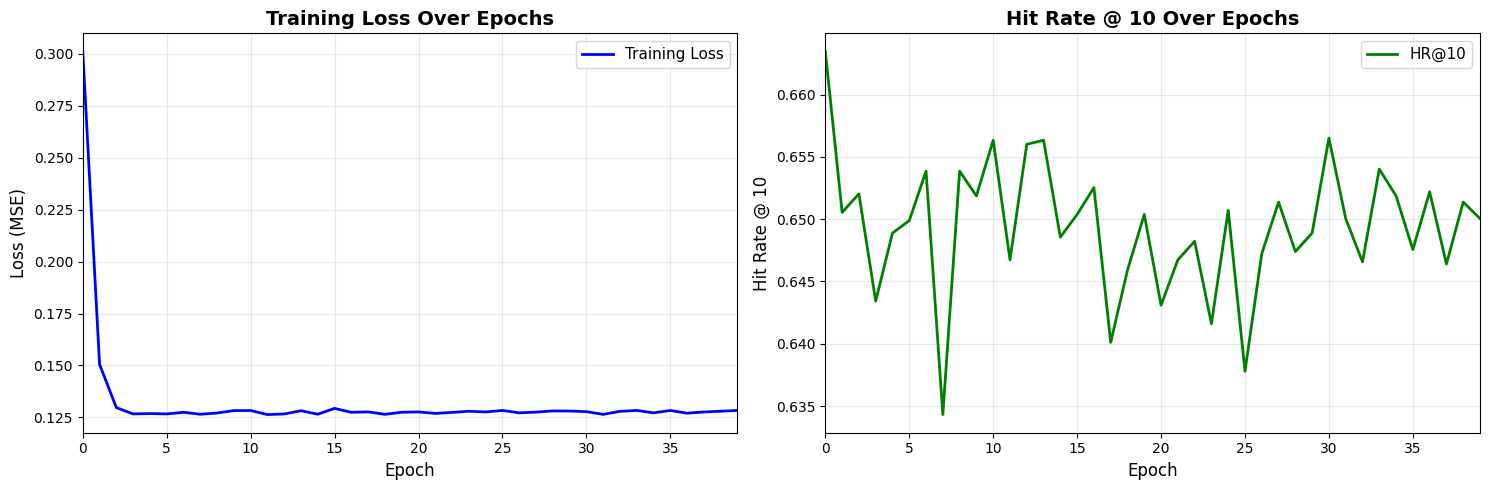

Training Summary
Final Training Loss: 0.128374
Best RMSE: 2.226939 (at epoch 17)
Best HR@10: 0.640113 (at epoch 17)
Best NDCG@10: 0.173461 (at epoch 17)


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss
epochs = range(len(train_losses))
ax1.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_xlim([0, len(epochs)-1])

# Plot 2: Hit Rate @ 10
ax2.plot(epochs, train_hr_at_10, 'g-', linewidth=2, label='HR@10')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Hit Rate @ 10', fontsize=12)
ax2.set_title('Hit Rate @ 10 Over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_xlim([0, len(epochs)-1])

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 70)
print("Training Summary")
print("=" * 70)
print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Best RMSE: {best_rmse:.6f} (at epoch {best_epoch})")
print(f"Best HR@10: {best_hr_at_10:.6f} (at epoch {best_epoch})")
print(f"Best NDCG@10: {best_ndcg_at_10:.6f} (at epoch {best_epoch})")
print("=" * 70)
